In [ ]:
import validation

In [23]:
# Fill in your names using the format below
your_name = "Rangaraj, Pavan Aakash"

In [24]:
# For use in colab
if 'google.colab' in str(get_ipython()):
  !python -m pip install geopandas contextily openml dirty_cat category_encoders gensim==3.8.3 --quiet

# Machine Learning Engineering - Assignment 2

This assignment will be all about building machine learning models on real-world data. We'll be looking at a challenging dataset containing more than 200,000 Airbnb listings in the United States. It is a good example of a real-world dataset combining multiple types of data (numeric, categorical, text, latitudes/longitudes, dates,...) and various real-world issues such as missing data and high-cardinality categorical features. You will need to do a lot of smart preprocessing and good model selection in order to build an well-working model. The main challenge will be to predict the price of Airbnb rentals based all the available data. Feel free to learn more about the dataset [here](https://www.openml.org/d/43369), and more about the meaning of the features [here](https://github.com/UBC-MDS/522_Airbnb_Listings_Amsterdam/blob/master/doc/main_report.md).

In [25]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml

### Additional packages:
* Geopandas and contextily (plot maps)
    - Run `pip install geopandas contextily shapely`
* dirty_cat (GAP feature encoding)
    - Run `pip install dirty_cat`
* category encoders (for target encoding)
    - Run `pip install category_encoders`
* gensim (for NLP)
    - Run `pip install "gensim==3.8.3"`

In [26]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import seaborn as sns
from tqdm.notebook import tqdm
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.2.0"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


## Data loading and cleaning
We'll first load the data and select the aspects that are useful for our problem.

In [5]:
# Download AirBnb data. Do not change this code and don't overwrite X or y.
# Note that X is a pandas dataframe 
airbnb = openml.datasets.get_dataset(43369)
X, y, _, feat_names = airbnb.get_data(target=airbnb.default_target_attribute)
print("The original data has {} rows and {} features".format(*X.shape))

The original data has 226030 rows and 17 features


In [6]:
from sklearn.model_selection import train_test_split

# Remove columns that are clearly not relevant to predict pricing
# The list ID is unique so it must be removed
# The host ID and host name are almost unique and not very useful either
# Last review is a date, which requires special handling, plus it is likely not very useful
X.drop(['id', 'host_id', 'host_name', 'last_review'], axis = 1, inplace = True)

# 'neighbourhood_group' is often missing but the dataset is very large.
# We'll drop the rows where this feature is missing so that we can also train models faster in this assignment.
X.dropna(subset=['neighbourhood_group'], inplace = True)
X.reset_index()

# Convert object columns to categorical columns
X.loc[:, X.dtypes == 'object'] = X.select_dtypes(['object']).apply(lambda x: x.astype('category'))


# 'name' is a short textual description, requiring NLP. We'll remove it for now and incorporate it later.
airbnb_names = X['name'].fillna(" ")
X.drop(['name'], axis = 1, inplace = True)

# We'll focus mainly on predicting the price of an airbnb given all information
# Setting the target (y) to be the price since this wasn't specified with the dataset
y = X['price']
X.drop('price', axis = 1, inplace = True)

print("The cleaned data has {} rows and {} features".format(*X.shape))

The cleaned data has 110185 rows and 11 features


### Data splits
We're making a few train-test splits to evaluate our models. Don't change or overwrite these!

In [7]:
# Taking a 50-50 train/test split. The dataset is quite large and this will speed up the training further
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

## Quick analysis
Let's peak at the data and how it's distributed.

In [8]:
X

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city
48150,Hawaii,Hamakua,20.040950,-155.432510,Entire home/apt,2,42,0.45,2,365,Hawaii
48151,Hawaii,South Kohala,20.027400,-155.702000,Entire home/apt,30,10,0.09,5,261,Hawaii
48152,Hawaii,South Kona,19.431190,-155.880790,Entire home/apt,5,168,1.30,3,242,Hawaii
48153,Hawaii,North Kona,19.564130,-155.963470,Entire home/apt,6,20,0.24,3,287,Hawaii
48154,Kauai,Koloa-Poipu,21.883050,-159.473720,Entire home/apt,3,143,1.03,1,116,Hawaii
...,...,...,...,...,...,...,...,...,...,...,...
212205,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,30,0,NaN,29,90,Seattle
212206,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,1,0,NaN,9,82,Seattle
212207,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,1,0,NaN,12,328,Seattle
212208,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,1,0,NaN,9,74,Seattle


### Geographical analysis

We can use the latitudes and longitudes for map their geographical distribution. The data is apparently only from NY, Washington, LA, Rhode Island, Seattle, and Hawaii, so we'll zoom in on these individually. We color-code the places by their price, from blue (cheap) to red (expensive), to check whether location tells us much about price. In New York, the effect of location is very mixed. For Hawai there seem to be some relationships. In any case, models should be able to handle complex local patterns to benefit from this.

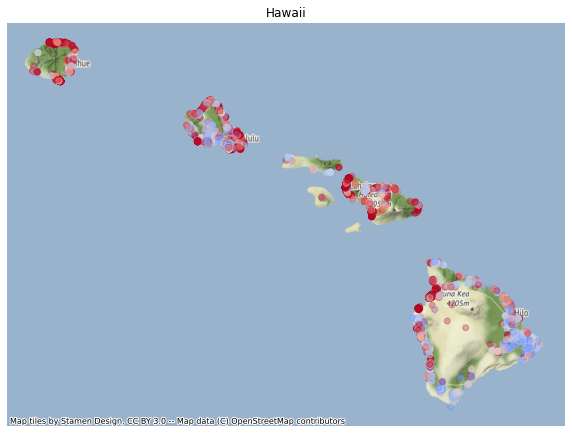

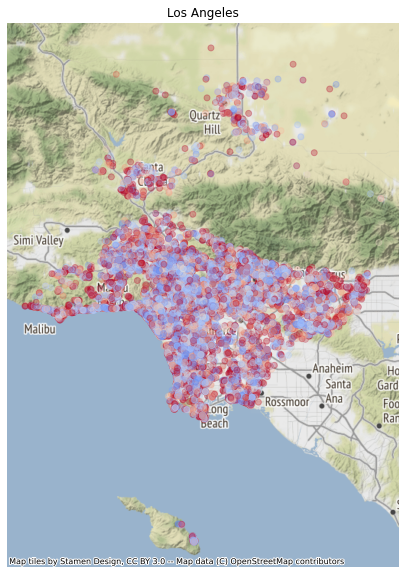

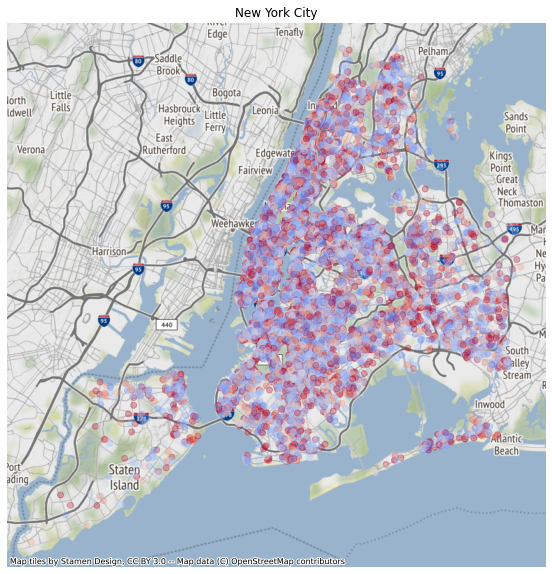

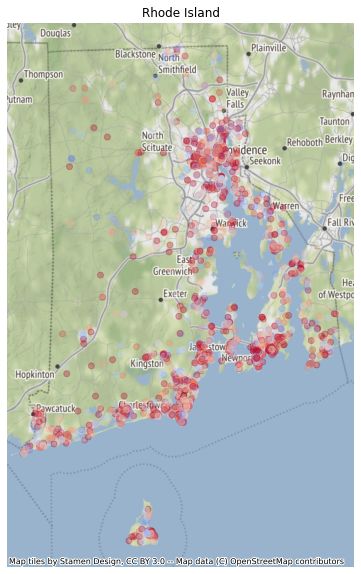

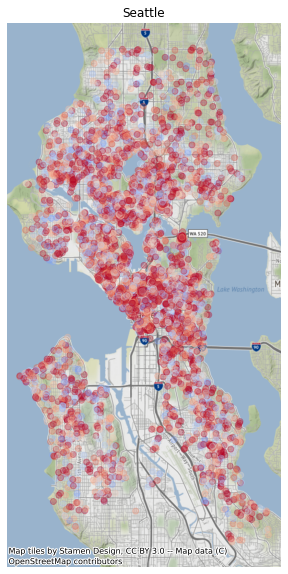

In [9]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import matplotlib.cm as cm

def plot_geo(X, color):
  """
  Plots the data points of X on a map, color-coded by the `color` value
  """
  gdf = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.longitude, X.latitude), crs="EPSG:4326")
  df_wm = gdf.to_crs(epsg=3857)
  ax = df_wm.plot(figsize=(10, 10), alpha=0.3, c=cm.coolwarm(color))
  cx.add_basemap(ax)
  plt.axis('off')

for city in X.city.unique():
  X_city = X[X.city==city]
  plot_geo(X_city,y)
  plt.title(city)

### Categorical features
There is an interesting mix of categorical and numeric features that will require more complex pipelines.

In [10]:
X.dtypes

neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
minimum_nights                       int64
number_of_reviews                    int64
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
city                              category
dtype: object

Neighborhood is a categorical feature with a *lot* of possible categories (635) and a long tail distribution. Here are the largest 100 categories:

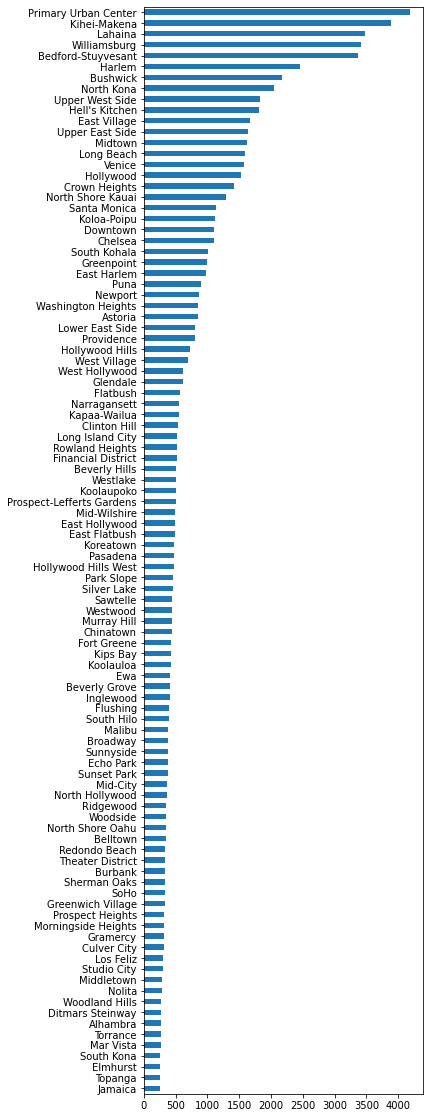

In [11]:
X.neighbourhood.value_counts().head(100)[::-1].plot(kind='barh', figsize=(5,20));

`Neighborhood_group` groups all neighborhoods in 34 categories.

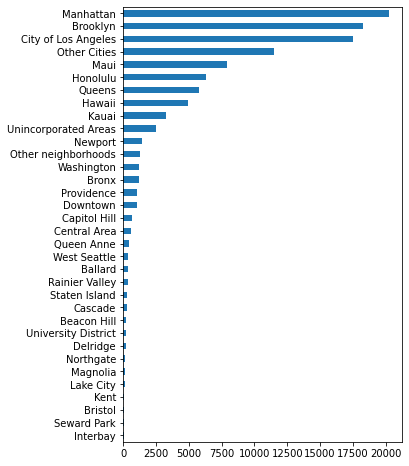

In [12]:
X.neighbourhood_group.value_counts()[::-1].plot(kind='barh', figsize=(5,8));

Most rooms are entire homes/appartments or private rooms.

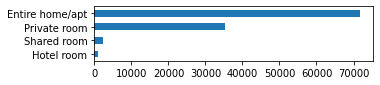

In [13]:
X.room_type.value_counts()[::-1].plot(kind='barh', figsize=(5,1));

### Numeric features
Distributions of all numeric features. In the second plot, we can see that expensive places usually have few reviews and can be rented any time of the year.

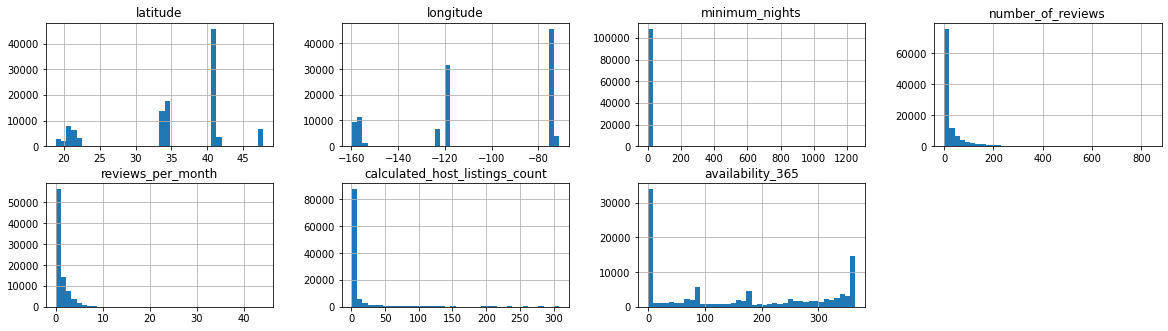

In [14]:
X.hist(layout=(7,4), figsize=(20,20), bins=40);

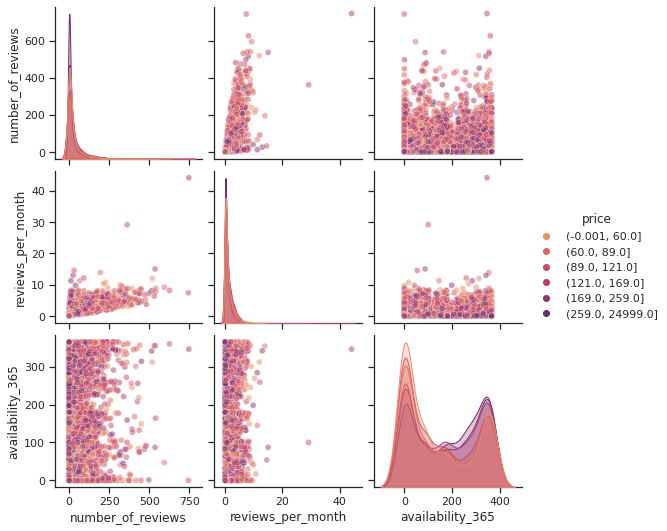

In [15]:
# Plot interaction between reviews, availability, and price
subset = ['number_of_reviews','reviews_per_month','availability_365']
X_sub=X_train[subset].copy(deep=True) # Deep copy is overkill but avoids some warnings
X_sub['price'] = pd.qcut(y, q=6)
sns.set(style="ticks")
sns.pairplot(X_sub.head(10000), hue="price", palette=sns.color_palette("flare"), plot_kws={'alpha':0.5});

### Missing values
Only 'reviews per month' has missing values. It seems that these are cases where there are no reviews.

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110185 entries, 48150 to 212209
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   neighbourhood_group             110185 non-null  category
 1   neighbourhood                   110185 non-null  category
 2   latitude                        110185 non-null  float64 
 3   longitude                       110185 non-null  float64 
 4   room_type                       110185 non-null  category
 5   minimum_nights                  110185 non-null  int64   
 6   number_of_reviews               110185 non-null  int64   
 7   reviews_per_month               85168 non-null   float64 
 8   calculated_host_listings_count  110185 non-null  int64   
 9   availability_365                110185 non-null  int64   
 10  city                            110185 non-null  category
dtypes: category(4), float64(3), int64(4)
memory usage: 11.3 MB


In [17]:
X[X.reviews_per_month.isna()]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city
48210,Hawaii,South Kona,19.268670,-155.876710,Entire home/apt,180,0,NaN,5,365,Hawaii
48295,Hawaii,North Kona,19.681130,-155.977390,Hotel room,2,0,NaN,4,345,Hawaii
48410,Kauai,Kapaa-Wailua,22.060450,-159.321830,Entire home/apt,1,0,NaN,90,306,Hawaii
48439,Honolulu,North Shore Oahu,21.669830,-158.044040,Entire home/apt,5,0,NaN,6,0,Hawaii
48441,Maui,Lahaina,20.923430,-156.693740,Entire home/apt,4,0,NaN,1,0,Hawaii
...,...,...,...,...,...,...,...,...,...,...,...
212205,Cascade,South Lake Union,47.624490,-122.335400,Entire home/apt,30,0,NaN,29,90,Seattle
212206,Downtown,Belltown,47.615020,-122.342490,Entire home/apt,1,0,NaN,9,82,Seattle
212207,Queen Anne,West Queen Anne,47.639570,-122.360840,Entire home/apt,1,0,NaN,12,328,Seattle
212208,Downtown,Belltown,47.615070,-122.340490,Entire home/apt,1,0,NaN,9,74,Seattle


### Prediction target
Let's also check the price distribution (not that this is on a log scale):

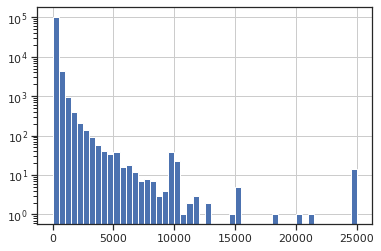

In [18]:
y.hist(bins=50, log=True);

What are these very expensive places? Some seem legit, but likely there are also a few with an exaggerated price because they don't actually want to rent them via airbnb. We'll leave them in since there are only a few.

In [19]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"name":airbnb_names[y>=20000],"price":y[y>=20000]})

,name,price
55106,4 Bedrooms! New Listing! Pool! Ocean Views! Gorgeous Home! - The Ka Lani Mai House,24999
56120,Royal Kailua Estate,20000
56176,The Sullivan Estate JK7 SPA Retreat,24600
57668,Dancing Bamboo Cottage - Minutes from Hawaii Volcanoes National Park! - Volcano Dancing Bamboo Cottage,24999
61834,"Kamaole Sands 9-207 Tastefully Decorated 1Bd/2Ba, Great Location and Rates!",24999
61875,"Kihei Bay Surf 257 Remodeled 2nd Flr Studio, Part. Ocean View, Great Rates!",24999
61913,"Maui Banyan Q403 1Bd/1Ba Partial Ocean View, Spacious Condo, A/C Sleeps 2-3",24999
61925,"Maui Banyan Q-403A Partial Ocean View Studio, Heart of South Kihei, Sleeps 2",24999
61941,"Wailea Point 3401 Exclusive Gated Complex on Wailea Beach, Partial Ocean View",24999
61943,"Maui Kamaole J-103 1Bd/2Ba Ground Floor, A/C, Across Kamaole III Beach",24999


Let's also divide these into classes by quartiles. It will likely be more feasible to predict the price category instead of the exact price.

In [20]:
y_class_labels = ['Cheap', 'Economy', 'Mid', 'Upscale', 'Premium', 'Luxury']
y_class = pd.qcut(y, q=[0, .25, .5, .75, .9, .95, 1], labels=y_class_labels)

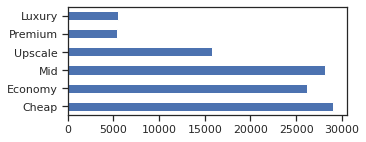

In [21]:
y_class.value_counts()[y_class_labels].plot(kind='barh', figsize=(5,2));

In [22]:
# Do the same 50-50 train/test split for the classes
# Since this split is stratified it will be a different split than before
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class, stratify=y_class, train_size=0.5, random_state=0)

## Part 1: A simple pipeline (15 points)

### Question 1.1: Pipeline design (5 points)
Implement a function `pipeline_builder` that returns an sklearn pipeline that preprocesses the data according to a number of options before training a model:
- Categorical features:
    - Add a categorical encoder for all categorical features. The default is one-hot encoding.
- Numeric features:
    - Handle missing values in the way that makes most sense for this data. Don't simply remove rows with missing values. 
    - Add an optional feature scaling method for al numeric features. The default is standard scaling. 'None' means no scaling.

**Note:** this function should not use any variables internally that are not passed as arguments (e.g. categorical columns must be derived from `X`, not by using the global `categorical` variable).

In [27]:
# This will be helpful, but do not use these as global variables in your functions!
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

In [28]:
# Implement
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def pipeline_builder(X, model, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes missing values and scales numeric features
    Keyword arguments:
      X -- The input data. Only used to identify features types (eg. numeric/categorical), not for training the pipeline.
      model -- any scikit-learn model (e.g. a classifier or regressor)
      scaler -- any scikit-learn feature scaling method (Optional)
      encoder -- any scikit-learn category encoding method (Optional)
      Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    pass

In [ ]:
validation.signature_unchanged(pipeline_builder)

### Question 1.2: Sanity check (1 point)
To be correct, this pipeline should be able to fit any classification or regression model without error. As a sanity check, use your function to evaluate a decision tree regression model, with `random_state=0` and otherwise default hyperparameter settings, and train it on the training split we defined above (e.g. `X_train`).

Hint: For the categorical feature encoding, you can set `sparse_output=False` to avoid that it returns a sparse datasets, and `handle_unknown='ignore'` to ignore categorical values that where not seen during training.

In [29]:
# Uncomment and implement
# pipe = None # replace with function call
# pipe.fit(X_train,y_train)

### Question 1.3: Data dimensionality (2 point)
How many features are being constructed by this pipeline (i.e., on how many features is the model trained)? Implement a function `feature_count` to return that number for a given pipeline.


In [ ]:
def feature_count(X, y, pipeline):
    """ Counts the number of features created in the preprocessing steps of the 
    given pipeline.
        X -- The input data.
        y -- The labels
        pipeline -- The pipeline that will transform the data
    Returns: The feature count (an integer)
    """
    pass

print("There are {} features".format(feature_count(X, y, None)))

In [2]:
# Store the correct answer, should be an integer. 
# You can update the function call, but don't change the name of the variable
q_1_3 = 0

In [ ]:
validation.signature_unchanged(feature_count)

### Question 1.4: Evaluation procedure (5 points)
Implement a function `evaluate_pipe` that evaluates the given `pipeline` using the given [scoring function](https://scikit-learn.org/stable/modules/model_evaluation.html) and 3-fold cross-validation (stratified for classification models). Also return the training time in seconds. Both should be averaged over all folds. Add an option `subsample_size` to take a subset of the data before running the cross-validation to allow faster experiments. This split should also be stratified for classification tasks.

Implement functions `evaluate_tree_regression` and `evaluate_tree_classification` to evaluate a decision tree model, with `random_state=0` and otherwise default hyperparameter settings. Use R2 for regression and AUC for classification. To compute multi-class AUC, use a one-vs-rest approach. Do this evaluation on the training splits we defined above (e.g. `X_train`), i.e. not taking a subsample. Note: you should still do 3-fold cross-validation over this training data. 

Store the scores and training times in the variables defined below, i.e. `reg_eval` and `clf_eval` for regression and classification, respectively.

Hint: `is_classifier` can be used to detect whether a model (or pipeline) is a classifier.

Hint 2: The default AUC scoring function may not work correctly out of the box. Make sure that you use the class probabilities (not the binary class predictions).

In [31]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Implement
def evaluate_pipe(X, y, pipeline, scoring, subsample_size=None):
    """ Evaluates the given pipeline using cross-validation on the given data
    Keyword arguments:
      X -- The input data.
      y -- The labels
      pipeline -- any scikit-learn pipeline (including a classifier or regressor)
      scoring -- the scoring function for the evaluation
      subsample_size -- Fraction of the input data to use for the cross-validation. 
                        If None, no subsample is made. If float in (0.0, 1.0), 
                        it takes that proportion of the dataset .
    Returns: a dictionary containing `score` and `fit_time` key-value pairs
    """
    pass

# Implement
def evaluate_tree_regression():
    """ Evaluates a decision trees on the regression task (price prediction).
    You can use the predefined train-test splits for this task.
    """
    pass

# Implement
def evaluate_tree_classification():
    """ Evaluates a decision trees on the classification task (price category prediction)
        You can use the predefined train-test splits for this task.
    """
    pass

In [ ]:
validation.signature_unchanged(evaluate_pipe)

In [ ]:
validation.signature_unchanged(evaluate_tree_regression)

In [ ]:
validation.signature_unchanged(evaluate_tree_classification)

In [32]:
# Storing and printing the results. No need to change this.
reg_eval = evaluate_tree_regression()
if reg_eval:
  print("Regression: {} R2 in {} seconds".format(reg_eval["score"],reg_eval["fit_time"]))
clf_eval = evaluate_tree_classification()
if clf_eval:
  print("Classification: {} AUC in {} seconds".format(clf_eval["score"],clf_eval["fit_time"]))

### Question 1.5: Interpretation (2 points)
Indicate which of the following are correct. Fill in your answer in q_1_3. Enter your answer as a comma-separated string without spaces-valued, e.g. "A,B,C"

- 'A': For regression, the decision tree is performing worse than simply predicting the average rental price.  
- 'B': For regression, the decision tree is significantly better than simply predicting the average rental price.
- 'C': For classification, the decision tree is performing worse or equal to random guessing.
- 'D': For classification, the decision tree is significantly better than random guessing.
- 'E': No answer.

Note: You don't need to run a statistical significance test. You can assume that a model is significantly better if it is at least 5% better (The R2 or AUC score is at least 0.05 higher).

In [33]:
# Fill in your interpretation. Don't change the name of the variable
q_1_3 = "E"

## Part 2: Pipeline optimization (17 points)

In the second part of this assignment we will focus on improving the data preprocessing.

### Question 2.1: Baseline performance (2 points)
First, let's set a strong baseline so that we can compare different alternative pipelines. Repeat the experiment from question 1.4, but now with gradient boosting, again on the full training set. We recommend using `HistGradientBoosting` since it is much faster (also faster than xgboost in our experiments). Set `random_state=0` and use the default hyperparameters (100 iterations). Store the scores and training times in the variables defined below, i.e. `reg_eval_boosting` and `clf_eval_boosting` for regression and classification, respectively. This should take about 5 minutes (tested on  Colab). 

Note: If for any reason you cannot run this reasonably fast, you can use a 50% subsample (using the `subsample_size` option).

In [34]:
def evaluate_boosting_regression():
    """ Evaluates a gradient boosting model with cross-validation on the regression task (price prediction)
    """
    pass

def evaluate_boosting_classification():
    """ Evaluates a gradient boosting model with cross-validation on the classifcation task (price category prediction)
    """
    pass

def evaluate_boosting_classification_test():
    """ Evaluates a gradient boosting model on the held-out test data for theclassifcation task (price category prediction)
    """
    pass

In [ ]:
validation.signature_unchanged(evaluate_boosting_regression)

In [ ]:
validation.signature_unchanged(evaluate_boosting_classification)

In [ ]:
validation.signature_unchanged(evaluate_boosting_classification_test)

In [35]:
# Storing and printing the results. Don't change this.
reg_eval_boosting = evaluate_boosting_regression()
if reg_eval_boosting:
  print("Regression (boosting): {} R2 in {} seconds".format(reg_eval_boosting["score"],reg_eval_boosting["fit_time"]))
clf_eval_boosting = evaluate_boosting_classification()
if clf_eval_boosting:
  print("Classification (boosting): {} AUC in {} seconds".format(clf_eval_boosting["score"],clf_eval_boosting["fit_time"]))
clf_eval_boosting_test = evaluate_boosting_classification_test()
if clf_eval_boosting_test:
  print("Classification (boosting) test score: {} AUC".format(clf_eval_boosting_test))

### Question 2.2: Better encodings (4 points)

The one-hot-encoder may not be ideal to encode the high-cardinality categorical features in this dataset (e.g. `neighbourhood`) since it generates a very large number of new binary features. In this case, it may be useful to learn a lower-dimensional embedding (a numerical vector representation) to represent these categories in fewer new features. One way to do this is to use *GAP encoding*, which works by first representing all category names as a bag-of-n-grams, and then applying a Gamma-Poisson matrix factorization to obtain a lower-dimensional latent representation. [This is illustrated nicely here](https://dirty-cat.github.io/stable/auto_examples/02_investigating_dirty_categories.html#example-gap-encoder).

It is included in the `dirty_cat` library, together with *similarity encoding* (which uses n-gram similarity between categories), and *MinHash encoding* (a more scalable variant for extremely high-cardinality features). [Read more about it here](https://arxiv.org/abs/1907.01860) but be aware that the paper is quite technical :).

Let's try it for our problematic `neighbourhood` feature. We can see that neighbourhoods like 'soho' and 'noho', or 'midtown' and 'downtown', get similar embeddings, but it's not clear whether this also helps with our price predictions.

In [36]:
from dirty_cat import GapEncoder

# Create a GAP encoder for 30 features
enc = GapEncoder(n_components=30, random_state=0)

# Embed the neighbourhood feature using the GAP encoder
X_neighborhood_enc = enc.fit_transform(X[["neighbourhood"]])

# To try and interpret the embedding, we can show the 3 neighborhoods with the 
# highest value for each feature (only the first 15 are shown here)
enc.get_feature_names_out(n_labels=3)[:15]

['greenpoint, green, sheepshead',
 'gramercy, prospect, lefferts',
 'village, schuylerville, middle',
 'heights, jackson, loyal',
 'center, interbay, burbank',
 'east, first, inwood',
 'haven, ravenna, bushwick',
 'wakefield, little, smithfield',
 'district, elmhurst, industrial',
 'sunset, park, narragansett',
 'beach, beacon, city',
 'midtown, downtown, town',
 'square, kitchen, ditmars',
 'flatbush, soho, noho',
 'williamsburg, adams, williamsbridge']

The `dirty_cat` library also includes the very handy `TableVectorizer` encoder that will try to automatically choose the best encoding to use. We can run it to see which encodings it would use on our data. It proposes to use GAP encoding with 30 components for `neighborhood`, and one-hot encodering for all other categorical features.

In [37]:
from dirty_cat import TableVectorizer

table_vec = TableVectorizer(auto_cast=True)
table_vec.fit_transform(X_train, y_train)
table_vec.transformers_

[('low_card_cat',
  OneHotEncoder(drop='if_binary', handle_unknown='ignore'),
  ['neighbourhood_group', 'room_type', 'city']),
 ('high_card_cat', GapEncoder(n_components=30), ['neighbourhood']),
 ('remainder',
  'passthrough',
  ['latitude',
   'longitude',
   'minimum_nights',
   'number_of_reviews',
   'reviews_per_month',
   'calculated_host_listings_count',
   'availability_365'])]

In [38]:
#Uncomment to see the list of all created features
#table_vec.get_feature_names_out()

To evaluate whether these embeddings are useful, a common approach is to map them to a 2D embedding using a dimensionality reduction technique so that we can plot them and see if similar data points are mapped to similar embeddings. We'll use the very popular [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) technique. Please read up on it a bit if you have never heard of it before.
* This should compress `X_neighborhood_enc` from (num_airbnbs, embedding_size) to an array of size (num_airbnbs, 2). Make sure that you don't overwite `X` or any other variable.
* Implement a function `plot_tsne` that plots the 2D vector as a scatter plot, color-coded by the rental price category (cheap, economy,...). Add a legend showing which color represents each class and make sure that the colors are clearly distinguishable.

Hint: tSNE has many hyperparameters. You can experiment with multiple settings. Initialization with PCA typically works well. You can also increase the perplexity parameter if initial results do not look good. Do at least several 100 iterations, up to 1000 (you can set `verbose=2` to observe how fast it convergences). Do train on all data if possible, since training on smaller subsamples usually gives worse results.


In [39]:
from sklearn.manifold import TSNE

# Implement
def compute_tsne(X):
  """ Applies tSNE to build a 2D representation of the data
  Returns a dataframe with the 2D representation
  X -- The input data
  """
  pass

# Implement
def plot_tsne(tsne_embeds, price_class):
  """ Plots the given 2D data points, color-coded by rent price classes
  tsne_embeds -- The tSNE embeddings of all neighborhoods
  scores -- The corresponding rent prices
  """
  pass

In [ ]:
validation.signature_unchanged(compute_tsne)

In [ ]:
validation.signature_unchanged(plot_tsne)

In [40]:
# Creates the embedding and plots. No need to change this. 
X_embed_2d = compute_tsne(X_neighborhood_enc)
plot_tsne(X_embed_2d, y_class.cat.codes)

### Question 2.3: Interpretation (1 point)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_2_3. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': We can clearly separate the different price classes of airbnbs based on the `neighborhood` feature alone.
- 'B': The result is entirely random because the name of the neighbourhood doesn't tell us anything useful about the rental price.
- 'C': Some (but not all) airbnbs of the same price category cluster together, so the GAP encodings are useful, but we'll still need to combine them with other features to make better predictions. Location isn't everything.
- 'D': The GAP encoding creates clear clusters of airbnbs, but there is no relationship with the rental price whatsoever, so it is useless.
- 'E': No answer

In [41]:
# Fill in your answer. Don't change the name of the variable
q_2_3 = "E"

### Question 2.4: Feature importance (4 points)
Another way to check the usefulness of a feature embedding is to use a feature selection technique and check if the created features are actually selected.

Implement a function `plot_feature_importance` that does the following:  
* Combine your pipeline builder with the `TableVectorizer` and a RandomForest classifier. Train that pipeline on the training set.
* Remember that the categorical features were encoded. Retrieve their encoded names from the TableVectorizer (using `get_feature_names_out()`). You can get the encoder from the trained pipeline or ColumnTransformer. Carefully check the documentation.
* Retrieve the feature importances from the trained random forest and match them to the correct names. This may depend on how you implemented your pipeline builder.
* Plot the feature importances (and the correct feature names_ as a bar chart.

In [42]:
# Implement
def plot_feature_importance(X, y):
    """ See detailed description above.
    """
    pass

# Call the function appropriately

In [ ]:
validation.signature_unchanged(plot_feature_importance)

### Question 2.5: Interpretation (1 points)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_2_5. Enter your answer as a comma-separated string without spaces,  e.g. "A,B,C".

- 'A': The neighborhood of an airbnb is clearly the most important feature. It's all you need to know. 
- 'B': It depends. Some neighborhood groups are clearly associated with high or low prices, but others are not predictive at all.
- 'C': The neighborhoods don't tell us anything. We might as well remove if from our data.
- 'D': The room type and city are still relatively important features. Some room types and cities are likely more expensive.
- 'E': Longitude and latitude are very important. That's because random forest decision trees are very deep and can learn very detailed 'boxes' or regions on the map with high or low prices.
- 'F': The number of reviews is the most important feature of them all.
- 'G': No answer

In [43]:
# Fill in your answer. Don't change the name of the variable
q_2_5 = "G"

### Question 2.6: Comparing category encoders (4 points)
Implement a function `plot_encoders` which plots a heatmap comparing several combinations of catergory encoders and models:
* As model, the following algorithms in their default hyperparameters settings: 
    * (Histogram-based) Gradient Boosting classification
    * Logistic regression
* As encoders, use the following options in their default settings:
    * One-Hot encoder (as before, with `sparse_output=False`)
    * One-Hot encoder with `max_categories=30`. This will only create one-hot encoded features for the most frequent categories and merge all the rest into a single category.
    * Ordinal encoder
    * TableVectorizer encoder (automated)

Use your pipeline builder and evaluation function defined in part 1 of this assignment. Only adjust the encoding strategy. Make sure that you compare all methods with the same cross-validation folds. Where possible, use `random_state=0` for the models. You can run initial experiments with a smaller `subsample_size`, but do report your final results on the entire training set.

We provide a helper function to generate a colored comparison table (i.e. a heatmap). Please use this if possible. You need to generate two heatmaps, one for the scores and one for the training times.

Note 1: When encoding categorical values, it is possible to see a category at test time that you did not see at training time. For one-hot encoded categories, you can work again ignore the category (all one-hot encoded features will then be zero). For ordinal encoding, you can assing a new value (e.g. '-1') for all unknown categories. For target encoding, the default is to return the target mean. These strategies can be set when creating the encodings.

Note 2: TargetEncoding is part of the `category_encoders` extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
We found that the implementation may have a bug that returns NaN values. You can work around it by wrapping it in a small pipeline followed by a SimpleImputer that replaces NaNs with the mean of the encoded values.

In [44]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    plt.figure() 
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [45]:
# Implement
def plot_encoders(X, y):
    """ Evaluates a range of models with different categorical encoders and 
    plots the results in a heat map.
    """
    pass

In [ ]:
validation.signature_unchanged(plot_encoders)

### Question 2.7: Interpretation (1 points)
Interpret the result. Are some combinations significantly better? You can interpret `significant` to mean an AUC difference of 1% or more. Indicate which of the following are correct? Fill in your answer in q_2_7. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': The TableVectorizer always gives the best results for all models (or about equally good as the best one).
- 'B': One-hot-encoding always gives the best results for all models (or about equally good as the best one).
- 'C': The ordinal encoder always gives the best results for all models (or about equally good as the best one).
- 'D': For Gradient boosting, the TableVectorizer and one-hot-encoding are about equally good, but the TableVectorizer is much faster.
- 'E': For Gradient boosting, the TableVectorizer and one-hot-encoding are about equally good, but the TableVectorizer is much slower.
- 'F': For Gradient boosting, the one-hot-encoding with a limited amount of features is about equally good as the full one-hot-encoding, and also much faster.
- 'G': Logistic regression gives the best results overall, since it learns directly how to combine the many different features, and the higher-dimensional feature space helps it learn very complex models.
- 'H': Gradient boosting works well no matter which encoding is used, even with ordinal encoding, since it selects only the most important features and it can split on features any way it wants to.
- 'I': One-hot-encoding doesn't work well since it generates too many features.
- 'J': If training time is an important factor, we should use gradient boosting with the ordinal encoder.
- 'K': No answer.

In [46]:
# Fill in your answer. Don't change the name of the variable
q_2_7 = "K"

## Part 3: Text embeddings and final model (8 points + 2 bonus points)
It's now time to re-introduce the `name` feature, which provides a short textual description of the airbnb. To include text features we need to again learn an embedding. We could learn such an embedding from scratch, but it is usually better to learn text embeddings on a very large corpus of text (e.g. Wikipedia). This works by first learning embeddings for words or n-grams, and then combining them into a final embedding for the whole description (or *document*). This is commonly called a Doc2Vec embedding. We will use a *pre-trained* embedding learned on Wikipedia, and use it to embed our airbnb descriptions. We will learn a lot more about this in lecture 10 - for now we will simply use these embeddings and give you the code to create them.

We have created a pre-trained Doc2Vec embedding on English Wikipedia for you. The code below downloads it and loads it into the `gemsim` library. This is a very useful NLP library.

In [ ]:
import gdown
import tensorflow as tf
import os
import tarfile
import gensim.models as g


data_dir = './' # Store the pretrained embedding model locally
if 'google.colab' in str(get_ipython()): # For use in colab
  data_dir = '/content'

if not os.path.exists(os.path.join(data_dir,"enwiki_dbow.tgz")):
    url = 'https://drive.google.com/uc?export=download&confirm=pbef&id=144J09ZWHBC32oh0NmDHL3EvJyYwQK21k'
    output = os.path.join(data_dir,"enwiki_dbow.tgz")
    gdown.download(url, output, quiet=False)

    # Extract the tar file
    file = tarfile.open(output)
    file.extractall(data_dir)
    file.close()

# Load model
# Note: The model is specific to the version of gensim. 
# The default one is created for gensim==3.8.3, which is supported in Colab
# We can create other versions as needed.
m = g.Doc2Vec.load("/content/enwiki_dbow/doc2vec.bin")

We can now embed the airbnb descriptions. We first need to tokenize them, and then we can infer the embedding. These embeddings are 300-dimensional.

In [48]:
from nltk.tokenize import word_tokenize, regexp_tokenize

# Tokenize the airbnb descriptions
descriptions = airbnb_names.fillna(" ") # Handle empty descriptions
tokenized_descriptions = []
for s in descriptions:
  tokenized_descriptions.append(regexp_tokenize(s.lower(), pattern=r"\s|[\.,;'\-!\*]", gaps=True))

# Example embedding
print(tokenized_descriptions[10])
len(m.infer_vector(tokenized_descriptions[10]))

['all', 'inclusive', 'that', 'has', 'it', 'all', 'sleeps', '8', 'hot', 'tub']


300

### Question 3.1: Using text embeddings (2 points)
Repeat question 2.2 but now with the Doc2Vec embeddings: train tSNE on the embeddings and visualize them in 2D.

Implement a function `create_doc2vec_embeddings` that infers the embeddings given the model and the (tokenized) airbnb descriptions. Next, implement a function `compute_doc2vec_tsne` to learn the tSNE embeddings. This could be identical to the `compute_tsne` function that you created before, but you can also tweak it (e.g. do fewer iterations). 

Finally, create the 2D scatter plot by training the tSNE model on all the data. You can reuse the `plot_tsne` function that you created before. You'll have to write the code that creates the correct embeddings and generates the plots this time, in function `plot_embeddings`. You don't need to plot all points, just the first 5000-10000 points should be ok. 

In [49]:
from sklearn.manifold import TSNE
import numpy as np

# Implement
def create_doc2vec_embeddings(model, tokenized_sentences):
  """ Uses the given Doc2Vec model to infer embeddings for the given (tokenized) sentences """
  pass

def compute_doc2vec_tsne(original_array):
  """ Applies tSNE to build a 2D representation of the data
  Returns a dataframe with the 2D representation
  original_array -- The input data
  """
  pass

def plot_embeddings():
  """ Uses the functions you created above to create the 2D scatter plot.
  """
  pass

plot_embeddings()

In [ ]:
validation.signature_unchanged(create_doc2vec_embeddings)

In [ ]:
validation.signature_unchanged(compute_doc2vec_tsne)

In [ ]:
validation.signature_unchanged(plot_embeddings)

### Question 3.2: Interpretation (1 point)
Interpret the result. Indicate which of the following are correct? Fill in your answer in q_3_2. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

- 'A': We can clearly separate the different price classes of airbnbs based on the host name description alone.
- 'B': The result is entirely random because the name of the host doesn't tell us anything useful about the rental price.
- 'C': Some (but not all) airbnbs of the same price category cluster together (or there is some visible structure), so the text encodings are useful, but we'll still need to combine them with other features to make better predictions.
- 'D': The text encoding creates clear clusters of airbnbs, but there is no relationship with the rental price whatsoever, so it is useless.
- 'E': No answer

In [60]:
# Fill in your answer. Don't change the name of the variable
q_3_2 = "E"

### Question 3.3: The final model (5 points + 2 bonus points)
You have learned a lot about this dataset and how to preprocess it. Now it's up to you to combine all this knowledge into building the best model for this dataset. You can use anything you did before (e.g. you can combine the text embeddings with other features), but you can also include techniques not covered here or elsewhere in the course. 

Implement a function `build_final_model` for the classification task. Train this model on the training data and evaluate it on the held-out test data (but obviously don't tune your models on the test data!). Store the test score in `q_3_3_score` (as indicated below).

Provide a textual explanation of what you did in `model_explanation`, what worked and what didn't. Don't use more than 500 characters for this.

The grade for this question will depend (50-50) on:
* The AUC performance of the model. It should be correctly evaluated and perform as least as well as the baseline test score from question 2.1.
* The creativity and correctness of your approach. 

You can get up to 2 bonus points if your model's performance is higher than 82.7% AUC and also clearly described in `model_explanation`. Explore, but don't invest too much time in this either, since it might be very difficult to do better.




In [53]:
from sklearn.manifold import TSNE

# Implement
def build_final_model(X,y):
  """ Build the best possible model (highest AUC score) for the given dataset.
  """
  pass

# Implement
def evaluate_final_model(X_train,y_train,X_test,y_test):
  """ Build and evaluate the model and return the AUC score
  """
  pass

# evaluate_final_model(X_class_train,y_class_train,X_class_test,y_class_test)

In [ ]:
validation.signature_unchanged(build_final_model)

In [ ]:
validation.signature_unchanged(evaluate_final_model)

In [54]:
# Fill in the score manually
q_3_3_score = 0.0

In [55]:
model_explanation = """
                    Explain how you arrived at this model. Use 500 characters or less.
                    """